In [1]:
from manifold_learning import CCM
from manifold_learning.data.data_loader import load_traffic_dataset
from manifold_learning.utils import utils
import importlib
import numpy as np
import matplotlib.pyplot as plt
importlib.reload(CCM)
importlib.reload(utils)
import os
import umap
import time

2024-06-13 12:52:09.607334: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 12:52:09.631049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 12:52:10.121088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
# Load traffic dataset
X = load_traffic_dataset()
page_names = X["Page"].to_numpy().astype("str")
X = X[X.columns[1:]]

df = X.T

# Interpolate missing values
df_interpolated = df.interpolate(method='linear', limit_direction='forward', axis=0)

# Fill any remaining missing values with zeros
df_filled = df_interpolated.fillna(0)
X = df_filled.to_numpy().astype(np.float32)


X = np.log(X+1)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
page_names = page_names[X.mean(axis=0) != 0]
X = X[:,X.mean(axis=0) != 0]
X = (X-X.mean(axis=0))/X.std(axis=0)

mask = (np.count_nonzero(np.diff(X[:,:],axis=0),axis=0) > 750)
X = X[:,mask]
page_names = page_names[mask]

In [5]:
ccm = CCM.FastCCM(device="cuda")

In [82]:
# Find optimal E and tau

E_range = np.arange(1,20)
tau_range = np.arange(1,20,2)
tp_max = 20

optimal_tau = []
optimal_E = []
value = []

for id in range(X.shape[1]):
    X_emb = np.concatenate([np.array([utils.get_td_embedding_np(X[:-tp_max,[id]],e,tau)[:,:,0] for e in E_range],dtype=object) for tau in tau_range])
    Y_emb = np.array([X[:,id][:i, None] for i in range(-(tp_max-1),-1)],dtype=object)
    res = ccm.compute(X_emb,Y_emb,500,150,10,10,0)[0].mean(axis=0).reshape(tau_range.shape[0],E_range.shape[0],)
    
    optimal_tau += [tau_range[np.unravel_index(np.argmax(res), res.shape)[0]]]
    optimal_E += [E_range[np.unravel_index(np.argmax(res), res.shape)[1]]]
    value  += [np.max(res)]
    print(id)
    
np.save("traffic_results/optimal_E.npy", np.array(optimal_E))
np.save("traffic_results/optimal_tau.npy", np.array(optimal_tau))
np.save("traffic_results/optimal_E_tau_rho.npy", np.array(value))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [7]:
optimal_E = np.load("traffic_results/optimal_E.npy")
optimal_tau = np.load("traffic_results/optimal_tau.npy")
value = np.load("traffic_results/optimal_E_tau_rho.npy")


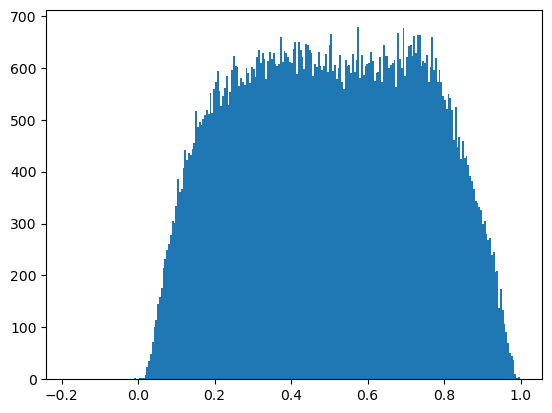

In [15]:
plt.hist(value,bins=250)
plt.show()

In [ ]:
st = time.time()
fp = np.memmap('traffic_results/full_ccm_matrix.dat', dtype='float16', mode='w+', shape=(X.shape[1], X.shape[1]))
blocksize = 150
for i in range(0, X.shape[1], blocksize):
    for j in range(0, X.shape[1], blocksize):
        X_emb = np.array([utils.get_td_embedding_np(X[:,[k]],optimal_E[k],optimal_tau[k])[:,:,0] for k in range(j,min(j+blocksize, X.shape[1]))],dtype=object)
        Y_emb = np.array([X[:,[k]] for k in range(i,min(i+blocksize, X.shape[1]))])
        block = ccm.compute(X_emb,Y_emb,500,150,10,10,0)[0].numpy().astype(np.float16)
        
        fp[i:i+blocksize, j:j+blocksize] = block
    
    print(i)

fp.flush()
del fp
print(time.time()-st)

0
150
300
450
600
750
900
1050
1200
1350
1500
1650
1800
1950
2100
2250
2400
2550
2700
2850
3000
3150
3300
3450
3600
3750
3900
4050
4200
4350
4500
4650
4800
4950
5100
5250
5400
5550
5700
5850
6000
6150
6300
6450
6600
6750
6900
7050
7200
7350
7500
7650
7800
7950
8100
8250
8400
8550
8700
8850
9000
9150
9300
9450
9600
9750
9900
10050
10200
10350
10500
10650
10800
10950
11100
11250
11400
11550
11700
11850
12000
12150
12300
12450
12600
12750
12900
13050
13200
13350
13500
13650
13800
13950
14100
14250
14400
14550
14700
14850
15000
15150
15300
15450
15600
15750
15900
16050
16200
16350
16500
16650
16800
16950
17100
17250
17400
17550
17700
17850
18000
18150
18300
18450
18600
18750
18900
19050
19200
19350
19500
19650
19800
19950
20100
20250
20400
20550
20700
20850
21000
21150
21300
21450
21600
21750
21900
22050
22200
22350
22500
22650
22800
22950
23100
23250
23400
23550
23700
23850
24000
24150
24300
24450
24600
24750
24900
25050
25200
25350
25500
25650
25800
25950
26100
26250
26400
26550
26700
26

In [ ]:
st = time.time()
fp = np.memmap('traffic_results/full_ccm_matrix_fixed_emb.dat', dtype='float16', mode='w+', shape=(X.shape[1], X.shape[1]))
blocksize = 500
for i in range(0, X.shape[1], blocksize):
    for j in range(0, X.shape[1], blocksize):
        X_emb = np.array([utils.get_td_embedding_specified(X[:,k],(0,2, 10, 40, 121)) for k in range(j,min(j+blocksize, X.shape[1]))])
        Y_emb = np.array([X[:,[k]] for k in range(i,min(i+blocksize, X.shape[1]))])
        block = ccm.compute(X_emb,Y_emb,500,150,10,10,0)[0].astype(np.float16)
        
        fp[i:i+blocksize, j:j+blocksize] = block
    
    print(i)

fp.flush()
del fp
print(time.time()-st)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
8500

In [13]:
matrix = np.memmap('traffic_results/full_ccm_matrix.dat', dtype="float16", mode='r', shape=(102391,102391))

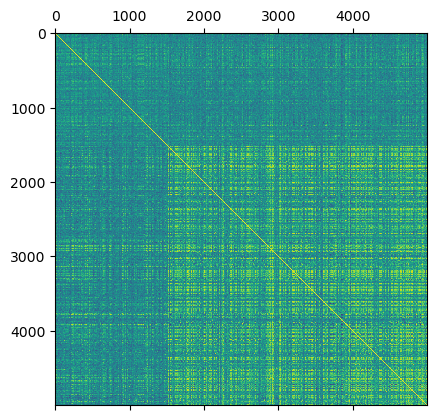

In [14]:
plt.matshow(matrix[:5000,:5000])


In [ ]:

idx = np.argsort(np.random.random(matrix.shape[0]))[:10000]

In [ ]:
corr = np.abs(np.corrcoef(X[:,idx].T))

In [ ]:
u = umap.UMAP(15,min_dist=0.25,metric='precomputed')

embedding = u.fit_transform(1-matrix[idx][:,idx])

/home/iaroslav/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [ ]:
rho_diff = (matrix[idx][:,idx] - corr)

In [64]:
corr[78,4747]

NameError: name 'corr' is not defined

In [65]:
matrix[idx[78],idx[4747]]

0.0465

In [ ]:
np.where(rho_diff > 0.9)

(array([  11,   11,   78, ..., 9997, 9997, 9997]),
 array([1827, 6726, 4747, ..., 5138, 6520, 9834]))

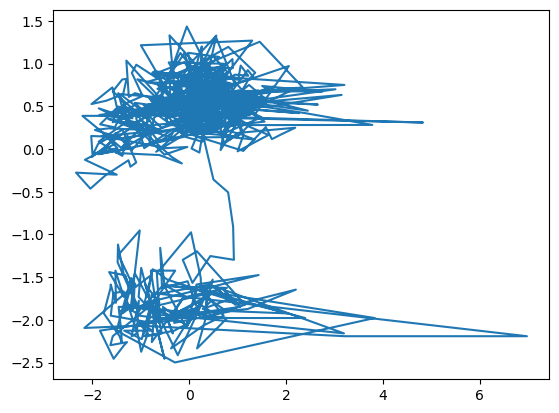

In [66]:
plt.plot(X[:,idx[5138]],X[:,idx[9997]])

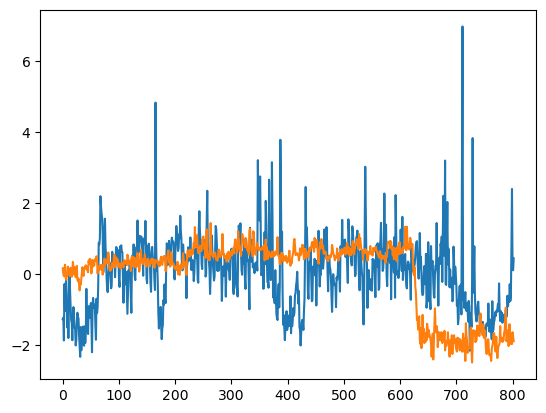

In [67]:
plt.plot(X[:,idx[5138]])
plt.plot(X[:,idx[9997]])

(array([2.0000000e+00, 2.0000000e+00, 4.0000000e+00, 8.0000000e+00,
        1.7000000e+01, 5.7000000e+01, 1.5000000e+02, 4.1500000e+02,
        1.1050000e+03, 2.4470000e+03, 5.1330000e+03, 9.3230000e+03,
        1.6111000e+04, 2.6851000e+04, 4.3403000e+04, 6.9743000e+04,
        1.1480400e+05, 1.9129400e+05, 3.2670400e+05, 5.6806200e+05,
        9.8939800e+05, 1.7077090e+06, 2.8673300e+06, 4.5510650e+06,
        6.6979880e+06, 8.9472430e+06, 1.0699893e+07, 1.1450781e+07,
        1.1022335e+07, 9.6688460e+06, 7.8985160e+06, 6.1159500e+06,
        4.5759890e+06, 3.3496000e+06, 2.4134270e+06, 1.7251080e+06,
        1.2244590e+06, 8.6281400e+05, 6.0733500e+05, 4.2536700e+05,
        2.9550000e+05, 2.0221900e+05, 1.3491500e+05, 8.6394000e+04,
        5.2526000e+04, 2.9784000e+04, 1.4483000e+04, 5.6780000e+03,
        1.5440000e+03, 1.6900000e+02]),
 array([-1.33918177, -1.29279082, -1.24639986, -1.20000891, -1.15361795,
        -1.107227  , -1.06083605, -1.01444509, -0.96805414, -0.92166319

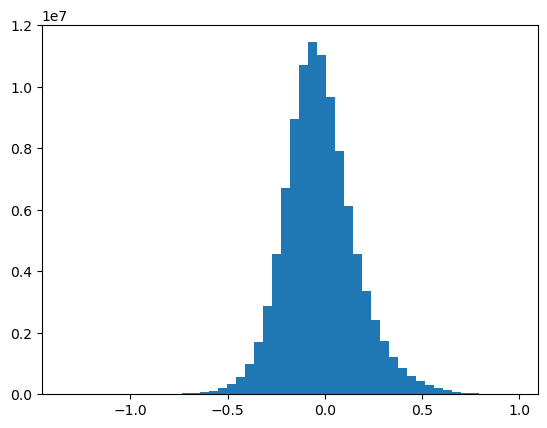

In [ ]:
plt.hist(rho_diff.flatten(),bins=50)

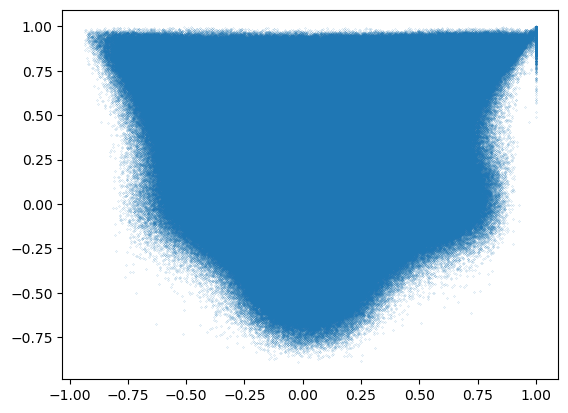

In [ ]:
plt.scatter(corr.flatten(),matrix[idx][:,idx].flatten(),s=0.01)

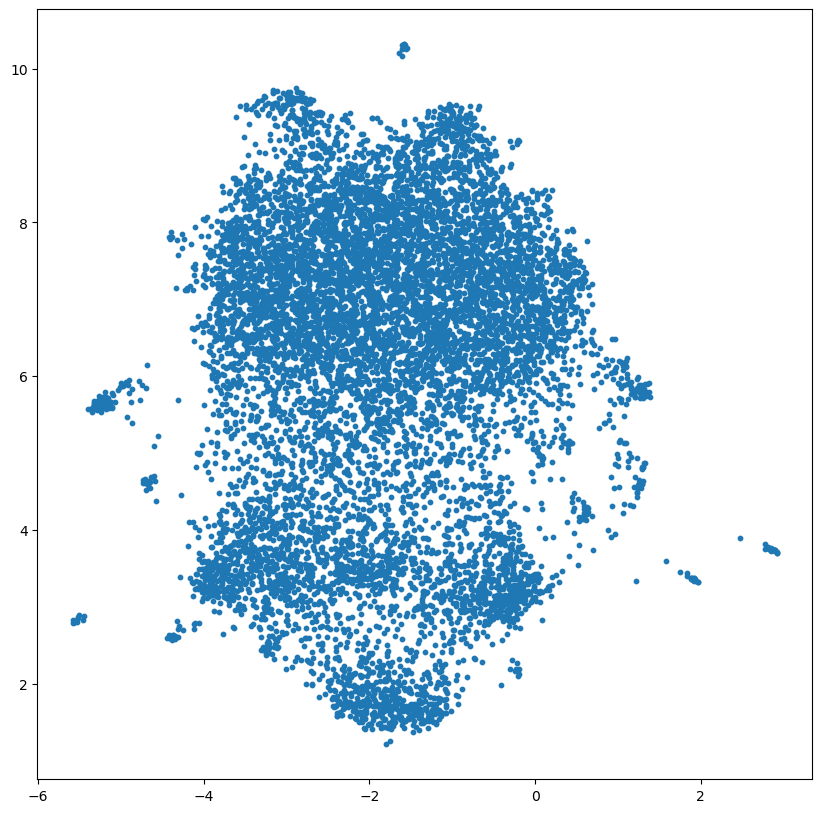

In [69]:
plt.figure(figsize=(10,10))
plt.scatter(*embedding.T,s=10)

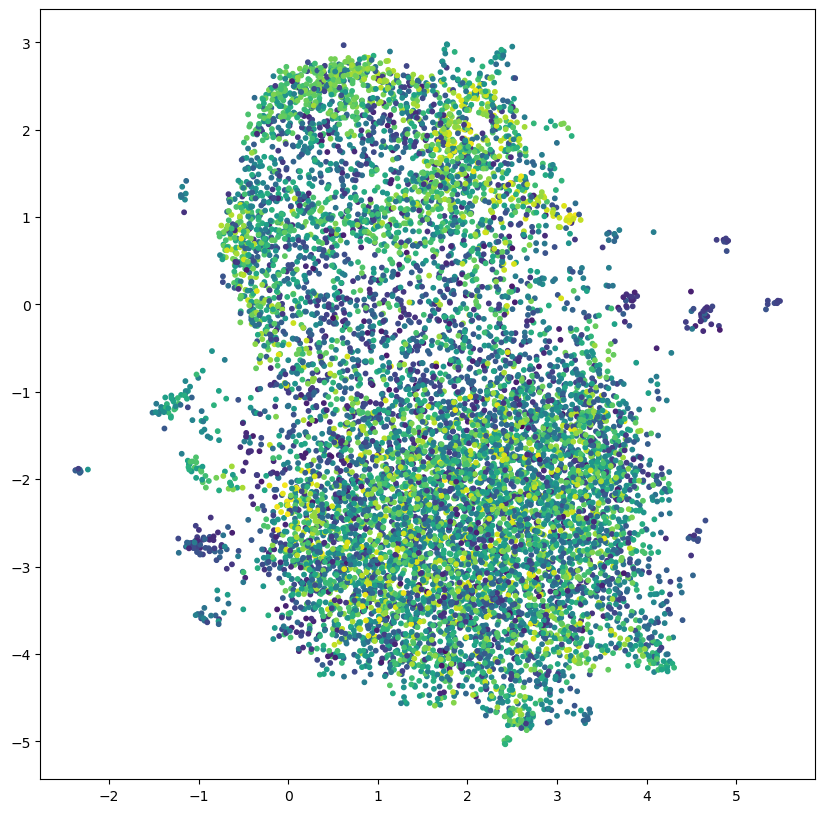

In [13]:
plt.figure(figsize=(10,10))
plt.scatter(*embedding.T,s=10,c=value[idx])